<a href="https://colab.research.google.com/github/Jacquet-G/IR_Project_2022/blob/main/Improved_IR_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# **<center>COVID-19 OPEN  RESEARCH DATASET  CHALLENGE (CORD-19) </center>**



## *First part*

Install of all library, we use the last version of ir_datasets and python-terrier.

All over the notebook we are going to import other library, we suppose them fully upgrade. It is very **important** to notice that the WordCloud library must **not** be fully upgrade, indeed the version 1.5.0 has to be used for better results. If a higher version is used, weired results may appear on word cloud graph ! 

In [ ]:
%%capture
!pip install ir_datasets
!pip install python-terrier

### Document

Importing the data relied for the documents

In [ ]:
# Import the dataset with the Python API. This is this dataset that we are using for all the first part. The second part will be done with PyTerrier.
#%%capture #you can freely chose to uncomment this line if you don't want to see the dowload of the dataset
import ir_datasets
dataset = ir_datasets.load("cord19/trec-covid")
for doc in dataset.docs_iter():
    doc

[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 [00:00<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M [00:00<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 57.3k/269M [00:00<09:09, 490kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.1%| 229k/269M [00:00<04:44, 945kB/s] 
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.4%| 1.03M/269M [00:00<01:35, 2.80MB/s]
https://ai2-semanticscholar-cord-

In [ ]:
# This following line show how to dowload the dataset with PyTerrier library.
#%%capture # Once again you can feel free to uncomment this line to not see the download.
import pyterrier as pt
if not pt.started() : pt.init()
datasetp = pt.get_dataset('irds:cord19/trec-covid')

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



All the pre-processing steps to apply to a dataset

In [ ]:
import regex as re
import string
import collections
from textblob import TextBlob
title = []
abstract = []

for doc in dataset.docs_iter():
    title.append(doc.title)
    abstract.append(doc.abstract)

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def character_repeatation(text):
    # Pattern matching for all case alphabets
    # \1   It refers to the first capturing group.
    # {1,} It means we are matching for repetition that occurs more than one time.
    # r’\1\1' → It limits all the repetition to two characters.
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    return Combined_Formatted

# An other step we can add is a spelling correction, but it is very time 
# consumming due to the number of word on the collection. That why we advise you
# to uncomment the following line only if you can wait a long time.
#def correction(text) :
#  text1 = TextBlob(text)        
#  textC = text1.correct()
# return textC

def pre_process(dataset) :
  n=0
  for t in dataset :
    dataset[n] = remove_punctuation(t)
    dataset[n] = character_repeatation(dataset[n])
    dataset[n] = dataset[n].lower() #Case folding
    dataset[n] = re.sub(r'\d+', '',dataset[n])
    n+=1
  return dataset

In [ ]:
pre_process(title)
print("pre processing done")

pre processing done


In [ ]:
pre_process(abstract)
print("pre processing done")

pre processing done


Tokenization to split the sentences of our dataset and get all the necessary tokens

And function words(...) to obtain three lists : 


*   token_list : list of token for each sentence of dataset
*   token : the list for all tokens
*   words_list : the list of all the tokens, *without stopwords or other words that will not be relevant for the next parts*



In [ ]:
from pandas.core.internals.base import T
import nltk
nltk.download('stopwords')

def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens

stop_words = nltk.corpus.stopwords.words('english')


def words(dataset, token_list = [], words_list = [], token = []) :
  if token_list != [] or words_list != [] or token != [] :
    token_list = []
    words_list = []
    token = []
  d=0
  for t in dataset :
    token_list.append(tokenization(t))
    for i in token_list[d] :
      token.append(i)
      if i not in stop_words and len(i) >=4 :
        words_list.append(i)
    d+=1
  return [words_list, token_list,token]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The count(..) function counts the frequency of each word in our words_list.

At the end, we prepared our final list so we could do the word cloud

In [ ]:
import pandas as pd

def count(words) :
  counter = collections.Counter(words)
  commons_words = counter.most_common(len(words))
  df = pd.DataFrame(commons_words)
  final_list = " ".join(words for words in df[0])
  return final_list

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def cloud(data_list) :
  word_cloud = WordCloud(collocations = False, background_color = 'white', stopwords= stop_words).generate(data_list)
  plt.imshow(word_cloud)
  plt.axis("off")
  plt.show()

In the next part, we obtain the two words clouds that we want

In [ ]:
# Compute varaibles to store every data for title and abstract
title_relevant_token, token_by_title , all_title_token = words(title)
abstract_relevant_token, token_by_abstract, all_abstract_token = words(abstract)

'covid coronavirus pandemic patients disease virus sarscov respiratory infection health acute study clinical review care novel syndrome analysis treatment severe human viral management using outbreak case china influenza impact response infections risk detection protein surgery infectious pneumonia epidemic cancer children sars role diseases systematic associated model laparoscopic potential patient system viruses cells cell control time among experience transmission report public global therapy lung early hospital evaluation outcomes medical cases research development data emergency approach effects diagnosis vaccine porcine effect molecular healthcare prevention trial social factors characteristics based rapid implications comparison surgical emerging challenges pulmonary first immune evidence mortality antiviral practice expression activity testing medicine crisis lessons type strategies characterization identification mental metaanalysis workers safety stroke recommendations italy 

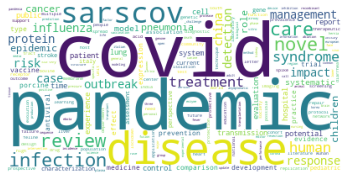

In [ ]:
title_most_common_terms = count(title_relevant_token)
display(title_most_common_terms)
cloud(title_most_common_terms)

'patients covid disease virus results infection study health respiratory clinical sarscov coronavirus data cases viral using methods treatment pandemic also risk used severe cells care studies group acute associated time analysis human viruses protein however compared high control including different model number infections patient significant among cell days first potential years background review syndrome system influenza rate conclusions significantly response based higher found diseases novel well reported mortality increased identified could public showed performed hospital case positive important symptoms infectious factors transmission outbreak research total infected outcomes present three medical development children evidence sars role included surgery management current groups levels findings population samples china conclusion within provide early measures spread available effective respectively many epidemic information mean immune activity common effects specific proteins 

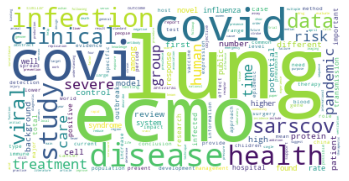

In [ ]:
abstract_most_common_terms = count(abstract_relevant_token)
display(abstract_most_common_terms)
cloud(abstract_most_common_terms)

We obtain here the number of tokens in the titles and in the abstracts

In [ ]:
print("Number of token for every title :    ", len(all_title_token),"\nNumber of token for every abstract : ", len(all_abstract_token))

Number of token for every title :     2410432 
Number of token for every abstract :  26093597


### Queries

Importing the dataset relied of the queries

In [ ]:
# We import the data from previous the dataset
#import ir_datasets
#dataset = ir_datasets.load("cord19/trec-covid")
queries = []
for query in dataset.queries_iter():
    queries.append(query.title)
    queries.append(query.description)
    queries.append(query.narrative)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [5.58MB/s]


In [ ]:
print(queries)

['coronavirus origin', 'what is the origin of COVID-19', "seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans", 'coronavirus response to weather changes', 'how does the coronavirus respond to changes in the weather', 'seeking range of information about the SARS-CoV-2 virus viability in different weather/climate conditions as well as information related to transmission of the virus in different climate conditions', 'coronavirus immunity', 'will SARS-CoV2 infected people develop immunity? Is cross protection possible?', 'seeking studies of immunity developed due to infection with SARS-CoV2 or cross protection gained due to infection with other coronavirus types', 'how do people die from the coronavirus', 'what causes death from Covid-19?', 'Studies looking at mechanisms of death from Covid-19.', 'animal models of COVID-19', 'what drugs have been active against SARS-CoV or SARS-CoV-2 in animal studies

In [ ]:
# We import here too, the queries but with the PyTerrier librairy
pttq_adhoc = datasetp.get_topics(variant='title')
pttq_des = datasetp.get_topics(variant='description')
pttq_nar = datasetp.get_topics(variant='narrative')

In [ ]:
datasetp.get_topics()

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


qid                                          title  \
0    1                             coronavirus origin   
1    2        coronavirus response to weather changes   
2    3                           coronavirus immunity   
3    4         how do people die from the coronavirus   
4    5                      animal models of COVID-19   
5    6                 coronavirus test rapid testing   
6    7              serological tests for coronavirus   
7    8                    coronavirus under reporting   
8    9                          coronavirus in Canada   
9   10           coronavirus social distancing impact   
10  11                 coronavirus hospital rationing   
11  12                         coronavirus quarantine   
12  13                    how does coronavirus spread   
13  14                    coronavirus super spreaders   
14  15                       coronavirus outside body   
15  16  how long does coronavirus survive on surfaces   
16  17                    coronavirus clinical trials   
17  18                      masks prevent coronavirus   
18  19       what alcohol sanitizer kills coronavirus   
19  20                 coronavirus and ACE inhibitors   
20  21                          coronavirus mortality   
21  22                      coronavirus heart impacts   
22  23                       coronavirus hypertension   
23  24                           coronavirus diabetes   
24  25                         coronavirus biomarkers   
25  26                     coronavirus early symptoms   
26  27                       coronavirus asymptomatic   
27  28                 coronavirus hydroxychloroquine   
28  29                   coronavirus drug repurposing   
29  30                         coronavirus remdesivir   
30  31         difference between coronavirus and flu   
31  32                           coronavirus subtypes   
32  33                 coronavirus vaccine candidates   
33  34                           coronavirus recovery   
34  35                    coronavirus public datasets   
35  36                     SARS-CoV-2 spike structure   
36  37               SARS-CoV-2 phylogenetic analysis   
37  38                    COVID inflammatory response   
38  39                        COVID-19 cytokine storm   
39  40                          coronavirus mutations   
40  41                  COVID-19 in African-Americans   
41  42                         Vitamin D and COVID-19   
42  43                       violence during pandemic   
43  44    impact of masks on coronavirus transmission   
44  45               coronavirus mental health impact   
45  46                      dexamethasone coronavirus   
46  47                  COVID-19 outcomes in children   
47  48                   school reopening coronavirus   
48  49               post-infection COVID-19 immunity   
49  50                       mRNA vaccine coronavirus   

                                          description  \
0                      what is the origin of COVID-19   
1   how does the coronavirus respond to changes in...   
2   will SARS-CoV2 infected people develop immunit...   
3                    what causes death from Covid-19?   
4   what drugs have been active against SARS-CoV o...   
5   what types of rapid testing for Covid-19 have ...   
6   are there serological tests that detect antibo...   
7   how has lack of testing availability led to un...   
8                    how has COVID-19 affected Canada   
9   has social distancing had an impact on slowing...   
10  what are the guidelines for triaging patients ...   
11  what are best practices in hospitals and at ho...   
12   what are the transmission routes of coronavirus?   
13  what evidence is there related to COVID-19 sup...   
14  how long can the coronavirus live outside the ...   
15  how long does coronavirus remain stable  on su...   
16  are there any clinical trials available for th...   
17  what are the best masks for preventing infecti...   
18  what typ

In [ ]:
# Save our queries depending their type
adhoc_queries = []
descriptives_queries = []
narratives_queries = []

for query in dataset.queries_iter():
  adhoc_queries.append(query.title)
  descriptives_queries.append(query.description)
  narratives_queries.append(query.narrative)

we create two data frame : one containing all the queries and the other one for the abstracts of the documents

In [ ]:
dfqTest = pd.DataFrame(data={'adhoc_query' : adhoc_queries,
                             'descriptive_query' : descriptives_queries,
                             'narrative_query' : narratives_queries})
dfdTest = pd.DataFrame(abstract, columns = ['abstract'])

We plot in the following lines the Word Cloud of most common term in the queries that are not pre_process. 

The goal is to see if there is an important difference between the WordCloud of all the queries, the adhocs queries, the descriptives queries and the narratives ones.

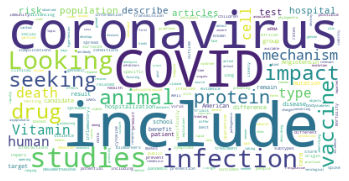

In [ ]:
most_common_terms_for_all_queries = count(words(queries)[0])
#display(most_common_terms_for_all_queries) #Uncomment this line to see the list of most common words
cloud(most_common_terms_for_all_queries)

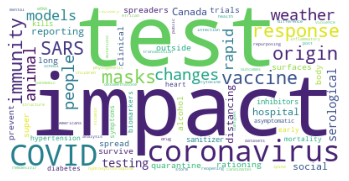

In [ ]:
# For adhocs queries
most_common_terms_for_adhoc_queries = count(words(dfqTest['adhoc_query'])[0])
#display(most_common_terms_for_adhoc_queries) #Uncomment this line to see the list of most common words
cloud(most_common_terms_for_adhoc_queries)

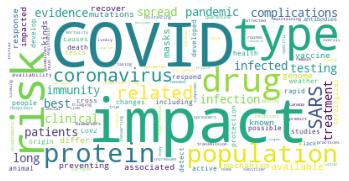

In [ ]:
# For descriptives queries
most_common_terms_for_descriptives_queries = count(words(dfqTest['descriptive_query'])[0])
#display(most_common_terms_for_descriptives_queries) #Uncomment this line to see the list of most common words
cloud(most_common_terms_for_descriptives_queries)

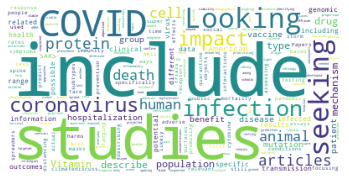

In [ ]:
# For narratives queries
most_common_terms_for_narratives_queries = count(words(dfqTest['narrative_query'])[0])
#display(most_common_terms_for_narratives_queries) #Uncomment this line to see the list of most common words
cloud(most_common_terms_for_narratives_queries)

The similarity between two queries is calculated with the help of the sklearn librairy and by using tf-idf vectorizer. We calculate the latter between each pair of query.

The get_pariwise_similarity is the implement function to achieved this goal.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

vect = TfidfVectorizer(min_df=1, stop_words="english") 

In [ ]:
def get_pairwise_similarity(vect : TfidfVectorizer, dataset : pd.core.series.Series) -> np.ndarray:
    tfidf = vect.fit_transform(dataset)
    pairwise_similarity = tfidf * tfidf.T
    return pairwise_similarity.toarray()

In [ ]:
# For adhoc queries
adhoc_pairwise_similarity = get_pairwise_similarity(vect, dfqTest['adhoc_query'])
print('Similarity matrix for adhoc queries : '+"\n",adhoc_pairwise_similarity,"\n")

# For descriptives queries
descriptives_pairwise_similarity = get_pairwise_similarity(vect, dfqTest['descriptive_query'])
print('Similarity matrix for descriptives queries : '+"\n",descriptives_pairwise_similarity,"\n")

# For narratives queries
narratives_pairwise_similarity = get_pairwise_similarity(vect, dfqTest['narrative_query'])
print('Similarity matrix for narratives queries : '+"\n",narratives_pairwise_similarity)

Similarity matrix for adhoc queries : 
 [[1.         0.0466173  0.08366651 ... 0.05501429 0.         0.05759065]
 [0.0466173  1.         0.05111578 ... 0.0336108  0.         0.03518482]
 [0.08366651 0.05111578 1.         ... 0.06032306 0.44406236 0.06314804]
 ...
 [0.05501429 0.0336108  0.06032306 ... 1.         0.         0.04152252]
 [0.         0.         0.44406236 ... 0.         1.         0.        ]
 [0.05759065 0.03518482 0.06314804 ... 0.04152252 0.         1.        ]] 

Similarity matrix for descriptives queries : 
 [[1.         0.         0.         ... 0.08819663 0.06150976 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.08309273 0.06962305]
 ...
 [0.08819663 0.         0.         ... 1.         0.02809779 0.        ]
 [0.06150976 0.         0.08309273 ... 0.02809779 1.         0.        ]
 [0.         0.         0.06962305 ... 0.         0.         1.        ]] 

Similarity matrix for

This function allows us to obtain for the query, that we want, a list containing the three other queries that are the most similar to it.

In [ ]:
def get_similar_queries(index_query : int, query_type : int, similarities : np.ndarray, qdataset : pd.DataFrame):
  similarity_list = []
    
  try : 
    query = qdataset.iloc[index_query,query_type]
    sim = similarities[index_query]
    index = np.argpartition(sim, -4)
    sim_query = qdataset.iloc[index[-4:],]
    similarity_list = [query, [q for q in qdataset.iloc[index[-4:],query_type][::-1] if q != query]]
    similarity_list_qids = [i+1 for i in index[-4:]]
  except : 
    return 'The index value is to high, the maximum is 49'
  return [similarity_list, similarity_list_qids]

We propose here an implementation of a fonction that compute the msot similar quiers for multiple initial queries.

In [ ]:
def get_similar_queries_multiple(index_queries : list, query_type : int, similarities : np.ndarray, qdataset : pd.DataFrame):
  return([get_similar_queries(q, query_type, similarities, dfqTest) for q in index_queries])

In [ ]:
# We test the previous function with two queries picked randomly by hand.
get_similar_queries_multiple([15,12],0,adhoc_pairwise_similarity, dfqTest)

[[['how long does coronavirus survive on surfaces',
   ['how does coronavirus spread',
    'coronavirus immunity',
    'coronavirus biomarkers']],
  [25, 3, 13, 16]],
 [['how does coronavirus spread',
   ['how long does coronavirus survive on surfaces',
    'coronavirus immunity',
    'coronavirus biomarkers']],
  [25, 3, 16, 13]]]

The following lines show the used of the previous function for each type of queries.

In [ ]:
# For adhocs queries
list_similar_adhoc_queries, list_similar_adhoc_queries_qids = get_similar_queries(15,0,adhoc_pairwise_similarity, dfqTest)
print('Initial query :',list_similar_adhoc_queries[0])
print('Most similar queries :',str(list_similar_adhoc_queries[1])[1:-1])

Initial query : how long does coronavirus survive on surfaces
Most similar queries : 'how does coronavirus spread', 'coronavirus immunity', 'coronavirus biomarkers'


In [ ]:
# For descriptives queries
list_similar_descriptives_queries, list_similar_descriptives_queries_qids = get_similar_queries(15,1,descriptives_pairwise_similarity, dfqTest)
print('Initial query :', list_similar_descriptives_queries[0])
print('Most similar queries :',str(list_similar_descriptives_queries[1])[1:-1])

Initial query : how long does coronavirus remain stable  on surfaces?
Most similar queries : 'how long can the coronavirus live outside the body', 'How does the coronavirus differ from seasonal flu?', 'how does the coronavirus respond to changes in the weather'


In [ ]:
# For narratives queries
list_similar_narratives_queries, list_similar_narratives_queries_qids = get_similar_queries(15,2,narratives_pairwise_similarity, dfqTest)
print('Initial query :', list_similar_narratives_queries[0])
print('Most similar queries :',str(list_similar_narratives_queries[1])[1:-1])

Initial query : Studies of time SARS-CoV-2 remains stable after being deposited from an infected person on everyday surfaces in a household or hospital setting, such as through coughing or touching objects.
Most similar queries : "seeking range of information on the SARS-CoV-2's virus's survival in different environments (surfaces, liquids, etc.) outside the human body while still being viable for transmission to another human", 'Looking for studies of how masks slow SARS-CoV-2 transmission, including impact on R0. Studies can include both lab and population studies.', 'Looking for information on all possible ways to contract COVID-19 from people, animals and objects'


We define a function to plot the WordCloud of the qids of similar queries. Because numbers can not ne considered as a text in the 1.5.0 version of WorldCloud we add the string 'qid_' to solve this problem. 

It is possible to notice that a include_numbers=True/False parameter are avaible on the constructor of the WordCloud class in last version of this librairy but using it generate strange results on above graphs so we choose to don't use it.

In [ ]:
# queries_index_list : list of int which are the index of the queries for each we will compile their 
# query_type : int in {0,1,2} for the type of the query 
# similarities : ndarray of pariwise similarities
# the two last parameters are required for the get_similar_queries()

def qids_cloud(queries_index_list : list, query_type : int, similarities : np.ndarray, qdataset : pd.DataFrame):
  _temp = []
  for queries_index in queries_index_list : 
    temp = get_similar_queries(queries_index, query_type, similarities, qdataset)[1]
    for t in temp : _temp.append(str(t))
  _res = " qid_".join(_t for _t in _temp) # must be an underscore "_" between the word and the number because ':','-' and '=' are automaticaly remove by the WorldCloud() function.
  cloud(_res)

Cloud of qids for similar adhoc queries : 



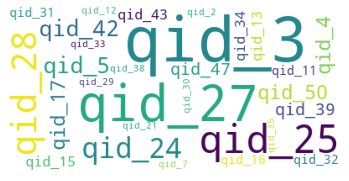

In [ ]:
print("Cloud of qids for similar adhoc queries : \n")
qids_cloud(np.random.randint(50, size=(30)), 0, adhoc_pairwise_similarity, dfqTest)

## Second *part*

### Indexing of the document

In [ ]:
import os
import pyterrier as pt
if not pt.started() : pt.init()

cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './terrier_cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
  # create the index, using the IterDictIndexer indexer 
  indexer = pt.index.IterDictIndexer(pt_index_path)

  # we give the dataset get_corpus_iter() directly to the indexer
  # while specifying the fields to index and the metadata to record
  index_ref = indexer.index(cord19.get_corpus_iter(), 
                            fields=('abstract',), 
                            meta=('docno','abstract'))
else:
  # if you already have the index, use it.
  index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
index_final = pt.IndexFactory.of(index_ref)

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

10:29:32.682 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
10:30:40.372 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 54937 empty documents
10:30:40.534 [ForkJoinPool-1-worker-3] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:346)
	at org.terrier.structures.indexing

In [ ]:
# We can see there some statistics for our collection.
print(index_final.getCollectionStatistics().toString())

Number of documents: 192509
Number of terms: 151235
Number of postings: 11554033
Number of fields: 1
Number of tokens: 17728468
Field names: [abstract]
Positions:   false



In [ ]:
# We compute another time all the datasets for clean one

title = []
abstract = []
for d in cord19.get_corpus_iter():
  title.append(d.get('title'))
  abstract.append(d.get('abstract'))

adhoc_queries = cord19.get_topics(variant='title')
descriptives_queries = cord19.get_topics(variant='description')
narratives_queries = cord19.get_topics(variant='narrative')

all_query_text = pd.DataFrame(data={'adhoc_query' : adhoc_queries['query'],
                             'descriptive_query' : descriptives_queries['query'],
                             'narrative_query' : narratives_queries['query']})
docs = pd.DataFrame(data = {'title' : title, 'abstract' : abstract})

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

In [ ]:
def token_per_sent(dataset) :
  i=0
  while i < len(dataset) :
    n=0
    index = []
    for w in dataset[i] :
      if w in stop_words or w == '' or len(w) < 4 :
        index.append(w)
      n+=1
    for m in index : 
      dataset[i].remove(m)
    i +=1
  return(dataset)

In [ ]:
# To remeber the last step of pre_process already done for the documents
pre_process(title)
pre_process(abstract)
print("pre process done")

title_relevant_token, token_by_title , all_title_token = words(title)
abstract_relevant_token, token_by_abstract, all_abstract_token = words(abstract)
token_per_sent(token_by_title)
token_per_sent(token_by_abstract)
print("tokenization done")

pre process done
tokenization done


### Pre-processing of the queries

In [ ]:
def process_query(type_query) :
  try :
    test = []
    for i in all_query_text[type_query] :
      test.append(tokenization(i))
    for j in test :
      pre_process(j)
    token_per_sent(test)
  except : 
    "The query's type possible are : adhoc_query, descriptive_query or narrative_query"
  return test

In [ ]:
def process_query_df(type_query) : 
  all = process_query(type_query)
  n=0
  for t in all : 
    all_query_text[type_query][n] = " ".join(t)
    n+=1
  return all

In the following line all the queries are pre_process using above functions.
The process has the same steps that the pre_processing for the documents.

In [ ]:
process_query_df("adhoc_query")
all_query_text["adhoc_query"].head(5)

0                      coronavirus origin
1    coronavirus response weather changes
2                    coronavirus immunity
3                      people coronavirus
4                     animal models covid
Name: adhoc_query, dtype: object

In [ ]:
process_query_df("descriptive_query")
all_query_text["descriptive_query"].head(5)

0                                         origin covid
1                  coronavirus respond changes weather
2    sars infected people develop immunity cross pr...
3                                   causes death covid
4                drugs active sars sars animal studies
Name: descriptive_query, dtype: object

In [ ]:
process_query_df("narrative_query")
all_query_text["narrative_query"].head(5)

0    seeking range information sars virus origin in...
1    seeking range information sars virus viability...
2    seeking studies immunity developed infection s...
3               studies looking mechanisms death covid
4    papers describe results testing drugs bind spi...
Name: narrative_query, dtype: object

### Running

In [ ]:
# For running experiments we firstly have to extract the qrels form the dataset.
qrels = cord19.get_qrels()
display(qrels.head(10))

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:08] [1.14MB] [138kB/s]


qid     docno  label iteration
0   1  005b2j4b      2       4.5
1   1  00fmeepz      1         4
2   1  010vptx3      2       0.5
3   1  0194oljo      1       2.5
4   1  021q9884      1         4
5   1  02f0opkr      1         1
6   1  047xpt2c      0       3.5
7   1  04ftw7k9      0         1
8   1  05qglt1f      0         1
9   1  05vx82oo      0         3

To perform Experiment we use the measures given by the PyTerrier librairy.

The goal is to compute the folloing metrics : P@5 (precision at 5), P@10 (precision a 10), NDCG (Normalize Discount Cumulative Gain), the Reciprocal Rank and finaly MAP (Mean Average Precision).

All those metrics will be perform for the three type of queries, adhoc, descriptives and narratives. 

All of these queries will have a basic index (an int from 1 to 50).

Finaly we are going to use two main weighting models during this process : tf-idf and BM25.


In [ ]:
# We construct our weighting model : 
tfidf = pt.BatchRetrieve(index_final, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index_final, wmodel="BM25")

In [ ]:
# Now we have to create dataframe for each type of query that contain the "qid" (an int between 1 an 50 in this case)
pt_adhoc_queries = pd.DataFrame({'qid' : [str(i) for i in range(1,51)], 'query' : all_query_text["adhoc_query"]})
pt_descriptives_queries = pd.DataFrame({'qid' : [str(i) for i in range(1,51)], 'query' : all_query_text["descriptive_query"]})
pt_narratives_queries = pd.DataFrame({'qid' : [str(i) for i in range(1,51)], 'query' : all_query_text["narrative_query"]})

In [ ]:
# Print to see if the query is a single string already pre-process which is a need for the pt.Experiment() function.
print(pt_adhoc_queries)

   qid                                  query
0    1                     coronavirus origin
1    2   coronavirus response weather changes
2    3                   coronavirus immunity
3    4                     people coronavirus
4    5                    animal models covid
5    6         coronavirus test rapid testing
6    7          serological tests coronavirus
7    8                  coronavirus reporting
8    9                     coronavirus canada
9   10   coronavirus social distancing impact
10  11         coronavirus hospital rationing
11  12                 coronavirus quarantine
12  13                     coronavirus spread
13  14            coronavirus super spreaders
14  15               coronavirus outside body
15  16      long coronavirus survive surfaces
16  17            coronavirus clinical trials
17  18              masks prevent coronavirus
18  19    alcohol sanitizer kills coronavirus
19  20                 coronavirus inhibitors
20  21                  coronaviru

In [ ]:
print(pt_descriptives_queries)

   qid                                              query
0    1                                       origin covid
1    2                coronavirus respond changes weather
2    3  sars infected people develop immunity cross pr...
3    4                                 causes death covid
4    5              drugs active sars sars animal studies
5    6                types rapid testing covid developed
6    7    serological tests detect antibodies coronavirus
7    8  lack testing availability underreporting true ...
8    9                              covid affected canada
9   10      social distancing impact slowing spread covid
10  11  guidelines triaging patients infected coronavirus
11  12  best practices hospitals home maintaining quar...
12  13                    transmission routes coronavirus
13  14             evidence related covid super spreaders
14  15                 long coronavirus live outside body
15  16            long coronavirus remain stable surfaces
16  17        

In [ ]:
print(pt_narratives_queries)

   qid                                              query
0    1  seeking range information sars virus origin in...
1    2  seeking range information sars virus viability...
2    3  seeking studies immunity developed infection s...
3    4             studies looking mechanisms death covid
4    5  papers describe results testing drugs bind spi...
5    6  looking studies identifying ways diagnose covi...
6    7  looking assays measure immune response covid h...
7    8  looking studies answering questions impact lac...
8    9  seeking data related infections confirm suspec...
9   10  seeking specific information studies measured ...
10  11  seeking information guidelines prioritizing co...
11  12  seeking information best practices activities ...
12  13  looking information possible ways contract cov...
13  14  seeking range information related number propo...
14  15  seeking range information sars virus survival ...
15  16  studies time sars remains stable deposited inf...
16  17  seekin

These lines and fucntion are a way to implement a table with all the previous measures compute for every type of queries.

In [ ]:
from pyterrier.measures import *

def evaluation(qdataset : pd.DataFrame):
  table = pt.Experiment(
    [tfidf, bm25],
    qdataset,
    qrels,
    eval_metrics=[P@5,P@10,"ndcg","recip_rank","map"],
    #round={P@5 : 3,P@10 : 3, "ndcg" : 3, "recip_rank" : 3, "map" : 3},
    names=['TF_IDF', 'BM25'])
  return(table)

#Second way to retrieve 
def evaluation2 (queries) :
  res = tfidf.transform(queries[['qid','query']])
  display(res.head(5))
  eval_top = pt.Utils.evaluate(res, cord19.get_qrels(),metrics=[P@5,P@10,"ndcg","recip_rank","map"],perquery=False)
  return eval_top

In [ ]:
# Before applying the previous fucntions we can test them on only one query and see if they correctly work.

print("Table test for the adhocs queries : \n",evaluation(pt_adhoc_queries.sample(1)))
print("\n Table test for the descriptives queries : \n",evaluation(pt_descriptives_queries.sample(1)))
print("\n Table test for narratives queries : \n",evaluation(pt_narratives_queries.sample(1)))

Table test for the adhocs queries : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  1.0   1.0  0.514703         1.0  0.318142
1    BM25  1.0   1.0  0.513207         1.0  0.313260

 Table test for the descriptives queries : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  1.0   1.0  0.450731         1.0  0.201795
1    BM25  1.0   1.0  0.471033         1.0  0.234147

 Table test for narratives queries : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.2   0.1  0.035024         1.0  0.002515
1    BM25  0.2   0.1  0.031786         1.0  0.002339


In [ ]:
print("Table for adhocs queries : \n",evaluation(pt_adhoc_queries))


print("\n Table for descriptives queries : \n",evaluation(pt_descriptives_queries))


print("\n Table for narratives queries : \n",evaluation(pt_narratives_queries))

Table for adhocs queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.668  0.624  0.364453    0.775853  0.173262
1    BM25  0.680  0.628  0.364684    0.773892  0.172613

 Table for descriptives queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.716  0.670  0.400411    0.808048  0.183681
1    BM25  0.692  0.658  0.403628    0.826746  0.185384

 Table for narratives queries : 
      name    P@5   P@10      ndcg  recip_rank      map
0  TF_IDF  0.588  0.570  0.315241    0.773068  0.13161
1    BM25  0.612  0.572  0.321848    0.769302  0.13555


In [ ]:
# We compare this result with the one obtain by the second methods to perform evaluation 
#to validate them. We can in this case only compare the values compute with the tf-idf model. 
print("Table for adhocs queries : \n",evaluation2(pt_adhoc_queries))


print("\n Table for descriptives queries : \n",evaluation2(pt_descriptives_queries))


print("\n Table for narratives queries : \n",evaluation2(pt_narratives_queries))

qid   docid     docno  rank     score               query
0   1  175892  zy8qjaai     0  7.080599  coronavirus origin
1   1   82224  8ccl9aui     1  6.775667  coronavirus origin
2   1  135326  ne5r4d4b     2  6.683114  coronavirus origin
3   1  122804  75773gwg     3  6.590340  coronavirus origin
4   1  122805  kn2z7lho     4  6.590340  coronavirus origin

Table for adhocs queries : 
 {'P@5': 0.6679999999999999, 'P@10': 0.6239999999999999, 'ndcg': 0.36445340233499657, 'recip_rank': 0.775853385930309, 'map': 0.1732615316510816}


qid   docid     docno  rank     score         query
0   1   83277  dv9m19yk     0  7.563897  origin covid
1   1  109967  kgifmjvb     1  7.301777  origin covid
2   1  135870  wmfcey6f     2  7.289201  origin covid
3   1   70706  qtx0d5f8     3  6.870516  origin covid
4   1   68581  4dtk1kyh     4  6.864158  origin covid


 Table for descriptives queries : 
 {'P@5': 0.7160000000000001, 'P@10': 0.67, 'ndcg': 0.4004107573813392, 'recip_rank': 0.808047619047619, 'map': 0.1836805036678434}


qid   docid     docno  rank      score  \
0   1  174658  tku1dr32     0  23.335714   
1   1  154740  apc0lm5e     1  22.968759   
2   1   78642  c834itam     2  22.252086   
3   1  141127  r71g2e9y     3  22.231584   
4   1  118377  dnla56uh     4  22.063778   

                                               query  
0  seeking range information sars virus origin in...  
1  seeking range information sars virus origin in...  
2  seeking range information sars virus origin in...  
3  seeking range information sars virus origin in...  
4  seeking range information sars virus origin in...


 Table for narratives queries : 
 {'P@5': 0.588, 'P@10': 0.5699999999999998, 'ndcg': 0.31524118198047735, 'recip_rank': 0.7730684955141476, 'map': 0.1316103547566718}


### Performing the previous steps

The aim of this part is the do every previous step but with a more developped pre procession that include a Stemming part. We will once again started from clean datas and so we download and store them another time.

In [ ]:
stemming_adhoc_queries = []
stemming_descriptives_queries = []
stemming_narratives_queries = []

for query in dataset.queries_iter():
  stemming_adhoc_queries.append(query.title)
  stemming_descriptives_queries.append(query.description)
  stemming_narratives_queries.append(query.narrative)

In [ ]:
stemming_all_query_text = pd.DataFrame(data={'adhoc_query' : stemming_adhoc_queries,
                             'descriptive_query' : stemming_descriptives_queries,
                             'narrative_query' : stemming_narratives_queries})
dfd = pd.DataFrame(data = {'title' : title, 'abstract' : abstract})

Here are an implementation of the new pre processing including Stemming.

In [ ]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming(text):
  stem_text = [porter_stemmer.stem(word) for word in text]
  return stem_text

def new_pre_process(dataset) :
  n=0
  for t in dataset :
    dataset[n] = remove_punctuation(t)
    dataset[n] = character_repeatation(dataset[n])
    dataset[n] = dataset[n].lower()
    dataset[n] = re.sub(r'\d+', '',dataset[n])
    n+=1
  return dataset

def new_process_query(type_query) :
  try :
    test = []
    n=0
    for i in stemming_all_query_text[type_query] :
      test.append(tokenization(i))
    for j in test :
      new_pre_process(j)
      test[n] = stemming(j)
      n+=1
    token_per_sent(test)
  except : 
    "The query's type possible are : adhoc_query, descriptive_query or narrative_query"
  return test

def new_process_query_df(type_query) : 
  all = new_process_query(type_query)
  n=0
  for t in all : 
    stemming_all_query_text[type_query][n] = " ".join(t)
    n+=1
  return all

In [ ]:
new_process_query_df('adhoc_query')
stemming_all_query_text["adhoc_query"].head(5)

0                   coronaviru origin
1    coronaviru respons weather chang
2                    coronaviru immun
3                    peopl coronaviru
4                    anim model covid
Name: adhoc_query, dtype: object

In [ ]:
new_process_query_df('descriptive_query')
stemming_all_query_text["descriptive_query"].head(5)

0                                        origin covid
1                    coronaviru respond chang weather
2    infect peopl develop immun cross protect possibl
3                                    caus death covid
4                               drug activ anim studi
Name: descriptive_query, dtype: object

In [ ]:
new_process_query_df('narrative_query')
stemming_all_query_text["narrative_query"].head(5)

0    seek rang inform viru origin includ evolut ani...
1    seek rang inform viru viabil differ weather cl...
2    seek studi immun develop infect cross protect ...
3                        studi look mechan death covid
4    paper describ result test drug bind spike prot...
Name: narrative_query, dtype: object

In [ ]:
new_pt_adhoc_queries = pd.DataFrame({'qid' : [str(i) for i in range(1,51)], 'query' : stemming_all_query_text["adhoc_query"]})
new_pt_descriptives_queries = pd.DataFrame({'qid' : [str(i) for i in range(1,51)], 'query' : stemming_all_query_text["descriptive_query"]})
new_pt_narratives_queries = pd.DataFrame({'qid' : [str(i) for i in range(1,51)], 'query' : stemming_all_query_text["narrative_query"]})

We now can compute every measure by taking in account the Stemming part in pre processing.

In [ ]:
from pyterrier.measures import *


print("Table for stremming adhocs queries : \n",evaluation(new_pt_adhoc_queries))


print("\n Table for stemming descriptives queries : \n",evaluation(new_pt_descriptives_queries))


print("\n Table for narratives queries : \n",evaluation(new_pt_narratives_queries))

Table for stremming adhocs queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.600  0.568  0.344973    0.709834  0.160249
1    BM25  0.612  0.568  0.345240    0.706651  0.160294

 Table for stemming descriptives queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.580  0.586  0.361772    0.685160  0.156491
1    BM25  0.552  0.560  0.364943    0.694752  0.158848

 Table for narratives queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.540  0.516  0.287859    0.690112  0.116279
1    BM25  0.548  0.524  0.293680    0.698575  0.119569


In [ ]:
# Once agian we compare the values of the metrics of the tf-idf model with the one obtain from the seconde method.
print("Table for stremming adhocs queries : \n",evaluation2(new_pt_adhoc_queries))


print("\n Table for stemming descriptives queries : \n",evaluation2(new_pt_descriptives_queries))


print("\n Table for narratives queries : \n",evaluation2(new_pt_narratives_queries))

qid   docid     docno  rank     score              query
0   1  175892  zy8qjaai     0  7.080599  coronaviru origin
1   1   82224  8ccl9aui     1  6.775667  coronaviru origin
2   1  135326  ne5r4d4b     2  6.683114  coronaviru origin
3   1  122804  75773gwg     3  6.590340  coronaviru origin
4   1  122805  kn2z7lho     4  6.590340  coronaviru origin

Table for stremming adhocs queries : 
 {'P@5': 0.6000000000000001, 'P@10': 0.568, 'ndcg': 0.34497323218446596, 'recip_rank': 0.7098339054108286, 'map': 0.16024936721978317}


qid   docid     docno  rank     score         query
0   1   83277  dv9m19yk     0  7.563897  origin covid
1   1  109967  kgifmjvb     1  7.301777  origin covid
2   1  135870  wmfcey6f     2  7.289201  origin covid
3   1   70706  qtx0d5f8     3  6.870516  origin covid
4   1   68581  4dtk1kyh     4  6.864158  origin covid


 Table for stemming descriptives queries : 
 {'P@5': 0.58, 'P@10': 0.5860000000000001, 'ndcg': 0.3617717623678817, 'recip_rank': 0.6851595881595882, 'map': 0.1564912593052746}


qid   docid     docno  rank      score  \
0   1   78642  c834itam     0  22.252086   
1   1   31423  h57k5vc4     1  21.328917   
2   1  174658  tku1dr32     2  20.135593   
3   1   96819  oi0zsdtd     3  20.093354   
4   1  171232  9il7coyk     4  20.093354   

                                               query  
0  seek rang inform viru origin includ evolut ani...  
1  seek rang inform viru origin includ evolut ani...  
2  seek rang inform viru origin includ evolut ani...  
3  seek rang inform viru origin includ evolut ani...  
4  seek rang inform viru origin includ evolut ani...


 Table for narratives queries : 
 {'P@5': 0.54, 'P@10': 0.5159999999999999, 'ndcg': 0.2878585870578283, 'recip_rank': 0.6901124661483244, 'map': 0.11627919533238817}


### Performance similarity analysis

The goal of the following lines is to compute every metrics for similiar queries and so give and answer to the question : Do similar queries have similar performance?

In [ ]:
# query_type int hase to be in {0,1,2} for adhoc, descriptive and narrative
# dataset has to be one of them : pt_adhoc_queries, pt_descriptives_queries, pt_narratives_queries
def measure_for_similiar_queries(index_query : int, type_query : int, qdataset : pd.DataFrame, allqdataset : pd.DataFrame):
  pt_pairwise_similarity = get_pairwise_similarity(vect, qdataset)
  list_similar_queries, list_similar_queries_qids = get_similar_queries(index_query, type_query, pt_pairwise_similarity, allqdataset)
  _temp = [list_similar_queries[0]]
  for q in list_similar_queries[1] : _temp.append(q)
  _sorted_index = []
  for q in _temp :
    for i in list_similar_queries_qids : 
      if qdataset[i-1] == q :
        _sorted_index.append(str(i))
  _temp_dataset_queries = pd.DataFrame({'qid' : _sorted_index, 'query' : _temp})
  for ind in range(len(_temp_dataset_queries)) :
    _temp_q = pd.DataFrame({'qid':[_temp_dataset_queries.iloc[ind,0]], 'query': [_temp_dataset_queries.iloc[ind,1]]})
    print("\n Table of evaluation by query : \n",evaluation(_temp_q))


In [ ]:
# For adhocs queries
print("Comparison of performance for similar adhocs queries : ")
measure_for_similiar_queries(15,0,pt_adhoc_queries['query'], all_query_text)

# We had a comparison with the same queries but with stemming in account 
print("\n Comparison of performance for similar stemming adhocs queries : ")
measure_for_similiar_queries(15,0,new_pt_adhoc_queries['query'], stemming_all_query_text)

Comparison of performance for similar adhocs queries : 

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  1.0   0.7  0.273948         1.0  0.068087
1    BM25  1.0   0.7  0.268047         1.0  0.063755

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.4   0.2  0.249196         1.0  0.070204
1    BM25  0.4   0.2  0.255012         1.0  0.072507

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.8   0.9  0.632019         1.0  0.349562
1    BM25  0.8   0.9  0.636255         1.0  0.354762

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.6   0.6  0.258429         1.0  0.064956
1    BM25  0.6   0.6  0.251310         1.0  0.058544

 Comparison of performance for similar stemming adhocs queries : 

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  1.

In [ ]:
# For descriptives queries
print("Comparison of performance for similar descriptives queries : ")
measure_for_similiar_queries(15,1,pt_descriptives_queries['query'], all_query_text)

print("\n Comparison of performance for similar stemming descriptives queries : ")
measure_for_similiar_queries(15,1,new_pt_descriptives_queries['query'], stemming_all_query_text)

Comparison of performance for similar descriptives queries : 

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.6   0.5  0.230772         1.0  0.043138
1    BM25  0.6   0.5  0.228768         1.0  0.040595

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.2   0.1  0.039761         0.5  0.001897
1    BM25  0.2   0.1  0.037567         0.5  0.001894

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.2   0.1  0.192501    0.333333  0.044787
1    BM25  0.2   0.1  0.190010    0.333333  0.042530

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.6   0.8  0.331844         1.0  0.128518
1    BM25  0.6   0.8  0.322277         1.0  0.122985

 Comparison of performance for similar stemming descriptives queries : 

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0

In [ ]:
# For narratives queries
print("Comparison of performance for similar narratives queries : ")
measure_for_similiar_queries(15,2,pt_narratives_queries['query'], all_query_text)

print("\n Comparison of performance for similar stemming narrativs queries : ")
measure_for_similiar_queries(15,2,new_pt_narratives_queries['query'], stemming_all_query_text)

Comparison of performance for similar narratives queries : 

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank      map
0  TF_IDF  0.2   0.4  0.246602         1.0  0.06055
1    BM25  0.6   0.4  0.253467         1.0  0.06356

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.2   0.1  0.035024         1.0  0.002515
1    BM25  0.2   0.1  0.031786         1.0  0.002339

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.4   0.3  0.207851         1.0  0.034107
1    BM25  0.4   0.3  0.219196         1.0  0.039459

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.8   0.9  0.356286         1.0  0.158425
1    BM25  0.8   0.9  0.358979         1.0  0.166102

 Comparison of performance for similar stemming narrativs queries : 

 Table of evaluation by query : 
      name  P@5  P@10      ndcg  recip_rank       map
0  TF_IDF

## Third part

In this third part we will first discuss an intuition we have and then we will try to improve the metrics by trying another indexing of the documents.

# Intuition 

From the second part we see that our metrics seems to be lower when we have few queries (one for example), but does this intuition can be verify or not ?

To try to answer this question we will once again use the pt.Experiment() function with a dataset of queries that going to be smaller and smaller.
Let's compute these metrics the dataset size equal at 75%, 50%, 25%, 10% of our original one. The select queries will be choose randomly.

We will do every step of every type of queries.

In [ ]:
def gradual_evaluation(type_queries) :
  query_test_75 = type_queries.sample(frac=0.75)
  query_test_50 = type_queries.sample(frac=0.50)
  query_test_25 = type_queries.sample(frac=0.25)
  query_test_10 = type_queries.sample(frac=0.10)

  table_eval_100 = evaluation(type_queries)
  table_eval_75 = evaluation(query_test_75)
  table_eval_50 = evaluation(query_test_50)
  table_eval_25 = evaluation(query_test_25)
  table_eval_10 = evaluation(query_test_10)

  print("\n Table for 100% of queries : \n", table_eval_100 )
  print("\n Table for 75% of queries : \n", table_eval_75)
  print("\n Table for 50% of queries : \n", table_eval_50)
  print("\n Table for 25% of queries : \n", table_eval_25)
  print("\n Table for 10% of queries : \n", table_eval_10)

In [ ]:
# For adhocs queries : 

print("\n Tables for adhocs queries :")
gradual_evaluation(pt_adhoc_queries)


 Tables for adhocs queries :

 Table for 100% of queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.668  0.624  0.364453    0.775853  0.173262
1    BM25  0.680  0.628  0.364684    0.773892  0.172613

 Table for 75% of queries : 
      name       P@5      P@10      ndcg  recip_rank       map
0  TF_IDF  0.668421  0.613158  0.342244    0.768667  0.157706
1    BM25  0.684211  0.621053  0.343285    0.770472  0.157627

 Table for 50% of queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.752  0.696  0.388705    0.882667  0.192825
1    BM25  0.768  0.700  0.387515    0.864048  0.191258

 Table for 25% of queries : 
      name       P@5      P@10      ndcg  recip_rank       map
0  TF_IDF  0.783333  0.733333  0.378597    0.847222  0.188620
1    BM25  0.816667  0.733333  0.377471    0.850000  0.185713

 Table for 10% of queries : 
      name   P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.68  0.60  0.299439    0.800000  0.11578

In [ ]:
# For descriptives queries :

print("\n Tables for descriptives queries :")
gradual_evaluation(pt_adhoc_queries)


 Tables for descriptives queries :

 Table for 100% of queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.668  0.624  0.364453    0.775853  0.173262
1    BM25  0.680  0.628  0.364684    0.773892  0.172613

 Table for 75% of queries : 
      name       P@5      P@10      ndcg  recip_rank       map
0  TF_IDF  0.684211  0.626316  0.364415    0.768950  0.176520
1    BM25  0.694737  0.628947  0.365017    0.777972  0.175566

 Table for 50% of queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.712  0.672  0.373805    0.801470  0.189547
1    BM25  0.720  0.672  0.376499    0.823803  0.189582

 Table for 25% of queries : 
      name       P@5      P@10     ndcg  recip_rank       map
0  TF_IDF  0.700000  0.658333  0.38102    0.789174  0.195735
1    BM25  0.716667  0.691667  0.38506    0.789174  0.198931

 Table for 10% of queries : 
      name   P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.68  0.60  0.415272         1.0  0.16

In [ ]:
# For narratives queries :

print("\n Tables for narratives queries :")
gradual_evaluation(pt_narratives_queries)


 Tables for narratives queries :

 Table for 100% of queries : 
      name    P@5   P@10      ndcg  recip_rank      map
0  TF_IDF  0.588  0.570  0.315241    0.773068  0.13161
1    BM25  0.612  0.572  0.321848    0.769302  0.13555

 Table for 75% of queries : 
      name       P@5      P@10      ndcg  recip_rank       map
0  TF_IDF  0.573684  0.550000  0.301457    0.766725  0.121776
1    BM25  0.610526  0.565789  0.308758    0.774320  0.125913

 Table for 50% of queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.528  0.536  0.297375    0.701898  0.136043
1    BM25  0.592  0.548  0.302628    0.695000  0.138884

 Table for 25% of queries : 
      name  P@5      P@10      ndcg  recip_rank       map
0  TF_IDF  0.6  0.591667  0.316123    0.796875  0.131365
1    BM25  0.6  0.591667  0.320631    0.748437  0.135853

 Table for 10% of queries : 
      name   P@5  P@10      ndcg  recip_rank       map
0  TF_IDF  0.52  0.46  0.302041    0.866667  0.124255
1    BM25  0

From the result we obtain we can say that less queries not necessary mean lower metrics in our model but overall the trend seems to be a decreasing of the metrics computed.

# New indexing

When we compute our first index we have choose only the abstract this time we will add the title too and compute all the metrics to see the evolution.

In [ ]:
if not os.path.exists(pt_index_path + "/data.properties"):
  # create the index, using the IterDictIndexer indexer 
  indexer = pt.index.IterDictIndexer(pt_index_path)

  # we give the dataset get_corpus_iter() directly to the indexer
  # while specifying the fields to index and the metadata to record
  index_ref = indexer.index(cord19.get_corpus_iter(), 
                            fields=('abstract','title',), 
                            meta=('docno','abstract','title'))
else:
  # if you already have the index, use it.
  index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
augmented_index = pt.IndexFactory.of(index_ref)

In [ ]:
# We construct our weighting model with the new index : 
tfidf = pt.BatchRetrieve(augmented_index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(augmented_index, wmodel="BM25")

We compute now every metrics with the new index

In [ ]:
print("Table for adhocs queries : \n",evaluation(pt_adhoc_queries))


print("\n Table for descriptives queries : \n",evaluation(pt_descriptives_queries))


print("\n Table for narratives queries : \n",evaluation(pt_narratives_queries))

Table for adhocs queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.668  0.624  0.364453    0.775853  0.173262
1    BM25  0.680  0.628  0.364684    0.773892  0.172613

 Table for descriptives queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.716  0.670  0.400411    0.808048  0.183681
1    BM25  0.692  0.658  0.403628    0.826746  0.185384

 Table for narratives queries : 
      name    P@5   P@10      ndcg  recip_rank      map
0  TF_IDF  0.588  0.570  0.315241    0.773068  0.13161
1    BM25  0.612  0.572  0.321848    0.769302  0.13555


In [ ]:
print("Table for stemming adhocs queries : \n",evaluation(new_pt_adhoc_queries))


print("\n Table for stemming descriptives queries : \n",evaluation(new_pt_descriptives_queries))


print("\n Table for stemming narratives queries : \n",evaluation(new_pt_narratives_queries))

Table for stemming adhocs queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.600  0.568  0.344973    0.709834  0.160249
1    BM25  0.612  0.568  0.345240    0.706651  0.160294

 Table for stemming descriptives queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.580  0.586  0.361772    0.685160  0.156491
1    BM25  0.552  0.560  0.364943    0.694752  0.158848

 Table for stemming narratives queries : 
      name    P@5   P@10      ndcg  recip_rank       map
0  TF_IDF  0.540  0.516  0.287859    0.690112  0.116279
1    BM25  0.548  0.524  0.293680    0.698575  0.119569
